In [2]:
from bokeh.io import output_notebook # to plot "show()" on the notebook, without opening a browser
output_notebook()

Loading BokehJS ...

In [3]:
from bloqade import var, save, load, piecewise_linear, rydberg_h
from bloqade.atom_arrangement import Chain, Square, Honeycomb
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
def rydberg_radius(omega, delta):
    C6 = 862690 * 2 * np.pi
    Ry = C6 / ((2*omega)**2 + delta**2)
    return Ry**(1/6)

## Defining the Geometry and Waveforms

### Geometry

In [5]:
n_atoms = 9
lattice_spacing = 6.1
atom_pos = Chain(n_atoms, lattice_spacing=lattice_spacing)

atom_pos.show()

### Waveforms

In [13]:
# State Preparation
delta_durations_state_prep = [0.3, 2.4, 0.3]
delta_state_prep = [-18.8, -18.8, 16.3, 16.3] # longer than durations by 1

omega_durations_state_prep = [0.3, 2.4, 0.3]
omega_state_prep = [0.0, 15.7, 15.7, 0.0] # longer than durations by 1

# Scaring
delta_durations_scaring = [0.2, 6.6]
delta_scaring = [16.3, 0.0, 0.0] # longer than durations by 1

omega_durations_scaring = [0.2, 1.4, 5.2]
omega_scaring = [0, 15.7, 15.7, 0] # longer than durations by 1

## Scar Program

In [20]:
run_time = var("run_time")

quantum_scar_program = (
    atom_pos
    # define detuning waveform
    .rydberg.detuning.uniform.piecewise_linear(
        delta_durations_state_prep, delta_state_prep # delta stateprep durations and values
    )
    .piecewise_linear(delta_durations_scaring, delta_scaring) # delta scaring durations and values
    # slice the detuning waveform
    .slice(start=0, stop=run_time)
    # define rabi waveform
    .amplitude.uniform.piecewise_linear(omega_durations_state_prep, omega_state_prep) # omega stateprep durations and values
    .piecewise_linear(omega_durations_scaring, omega_scaring) # omega scaring durations and values
    # slice waveform, add padding for the linear segment
    .slice(start=0, stop=run_time - 0.065)
    # record the value of the waveform at the end of the slice to "rabi_value"
    .record("rabi_value")
    # append segment to waveform that fixes the value of the waveform to 0
    # at the end of the waveform
    .linear("rabi_value", 0, 0.065)
)

# get run times via the following:
prep_times = np.array([3])
scar_times = np.arange(3, 4, 0.1)
run_times = np.unique(np.hstack((prep_times, scar_times)))

batch = quantum_scar_program.batch_assign(run_time=run_times)

print(f"State preparation ends at task {len(prep_times)}")
print(f"Tasks in total: {len(run_times)}")

State preparation ends at task 1
Tasks in total: 10


## Running the Experiments

In [21]:
num_shots = 100
emu_batch = batch.bloqade.python().run(num_shots, interaction_picture=True)

In [22]:
emu_batch.report().show()

In [23]:
def Z2(L, prime=True, label_output=True):
    label = ''
    for i in range(L):
        if prime:
            label += str(i % 2)
        else:
            label += str((i + 1) % 2)
    if label_output:
        return label
    else:
        return np.array(Statevector.from_label(label))

def get_z2_probabilities(report):
    z2_probabilities = []

    for count in report.counts():
        z2_probability = count.get("010101010", 0) / sum(list(count.values()))
        z2_probabilities.append(z2_probability)

    return z2_probabilities

from qiskit.quantum_info import Statevector
def get_z2_corrected_probabilities(report):
    def dict_to_state(d):
        first_label = list(d.keys())[0]
        num_qubits = len(first_label)
        num_shots = sum(d.values())
        state = np.sqrt(d[first_label]/num_shots)*Statevector.from_label(first_label)

        for label in list(d.keys())[1:]:
            state += np.sqrt((d[label]/num_shots))*Statevector.from_label(label)
        return state, num_qubits

    def mitigate(num_qubits, dagger=True):
        E = np.sqrt(np.array([[0.99, 0.01], 
                      [0.05, 0.95]]))
        op = E
        for i in range(num_qubits-1):
            op = np.kron(op, E)
        if dagger:
            return op.conj().T
        else:
            return op
    
    probs = []
    for d in report:
        sv, num_qubits = dict_to_state(d)
        corrected_sv = mitigate(num_qubits).dot(sv)
        corrected_sv = Statevector((1/np.linalg.norm(corrected_sv))*corrected_sv)
        probs.append(np.real(np.inner(corrected_sv.conjugate(), Statevector.from_label(Z2(num_qubits)))))
    return probs

In [24]:
z2_probabilities = get_z2_probabilities(emu_batch.report())
z2_corrected_probabilities = get_z2_corrected_probabilities(emu_batch.report().counts())

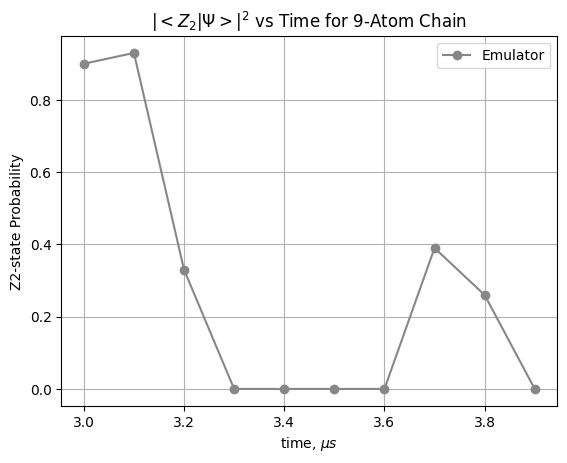

In [25]:
plt.plot(run_times, z2_probabilities, 'o-', label="Emulator", color="#878787")
# plt.plot(run_times, z2_corrected_probabilities, 'o-', label="Corrected Emulator", color="black")
plt.xlabel('time, $\mu s$')
plt.ylabel(f"Z2-state Probability")
plt.title(f'$|<Z_2|\Psi>|^2$ vs Time for {n_atoms}-Atom Chain')
plt.legend()
plt.grid()

In [79]:
for x, y in zip(run_times, z2_probabilities):
    print((round(x, 1), y), end=', ')

(2.2, 0.846), (2.3, 0.864), (2.4, 0.912), (2.5, 0.83), (2.6, 0.38), (2.7, 0.03), (2.8, 0.0), (2.9, 0.004), (3.0, 0.012), (3.1, 0.028), (3.2, 0.006), (3.3, 0.0), (3.4, 0.006), (3.5, 0.07), (3.6, 0.386), (3.7, 0.56), (3.8, 0.252), (3.9, 0.048), (4.0, 0.004), (4.1, 0.012), (4.2, 0.012), (4.3, 0.008), (4.4, 0.018), (4.5, 0.01), (4.6, 0.012), (4.7, 0.18), (4.8, 0.362), (4.9, 0.306), (5.0, 0.104), (5.1, 0.03), (5.2, 0.018), (5.3, 0.052), (5.4, 0.07), (5.5, 0.018), (5.6, 0.006), (5.7, 0.004), (5.8, 0.074), (5.9, 0.2), (6.0, 0.35), (6.1, 0.244), (6.2, 0.024), (6.3, 0.018), (6.4, 0.01), (6.5, 0.054), (6.6, 0.086), (6.7, 0.072), (6.8, 0.056), (6.9, 0.012), (7.0, 0.012), (7.1, 0.086), (7.2, 0.19), (7.3, 0.216), (7.4, 0.212), (7.5, 0.14), (7.6, 0.084), (7.7, 0.084), (7.8, 0.048), (7.9, 0.07), (8.0, 0.066), (8.1, 0.054), (8.2, 0.056), (8.3, 0.046), (8.4, 0.046), (8.5, 0.01), (8.6, 0.036), (8.7, 0.222), (8.8, 0.178), (8.9, 0.082), 